# Moving Average Crossover Trading Strategies

This notebook demonstrates the Simple Moving Average Crossover (SMAC) trading strategy and the Exponentially Weighted Moving Average Crossover (EWMAC) trading strategy, and applies these strategies to five fuel and five equity futures contracts.

To run any of the strategies, run the code under Sections 1 and 2

* [Section 1](#imports): Imports
* [Section 2](#read_data): Reading and pre-processing data

Then run the code under either:

* [Section 3](#sma) to run the SMAC strategy
* [Section 4](#ewmac) to run the EWMAC strategy

<div class="alert alert-block alert-info">
<b>Note:</b> The data used in this notebook is sourced from FirstRate Data. To run this notebook, the FirstRate Data, or equivalent data in the same format, is required. </div>

### 1. Imports

In [21]:
import pandas as pd
import csv

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Required for using pysystemtrade
import os, sys
sys.path.append(os.path.abspath('../pysystemtrade'))

from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
from systems.accounts.account_forecast import pandl_for_instrument_forecast

# Set the default font size for plots
plt.rcParams.update({
    "font.size": 16,
    "legend.fontsize": 14
})


### 2. Reading and pre-processing data
We convert parquets into CSV files for pysystemtrade. Pysystemtrade creates its own Data objects by reading in csv files with a particular format. Therefore we need to convert the parquet files to csv in the proper format.

In [22]:
# Define the data paths according to the structure of the project
FUEL_FUTURES_PATH = '../data/fuel_first_rate_data_R_prices.parquet'
EQUITY_FUTURES_PATH = '../data/equity_indices_first_rate_data_R_prices.parquet'

# This is where csv files must be placed for pysystemtrade to access them
CSV_PATH = '../pysystemtrade/data/firstrate_futures/test'

In [23]:
# Read in data
start_datetime = '2018-01-02'

fuel_futures_data = pd.read_parquet(FUEL_FUTURES_PATH)[start_datetime:]
equity_futures_data = pd.read_parquet(EQUITY_FUTURES_PATH)[start_datetime:]

In [24]:
# Function to convert data in a futures data file into individual csv files
def convert_parquet_to_csv(src_dataframe: pd.DataFrame, dst_path: str, symbols: list) -> None:
    """_summary_

    Args:
        src_path (str): _description_
        dst_path (str): _description_
    """

    for i, column in enumerate(symbols):

        dst_filename = dst_path + f'/{symbols[i]}.csv'

        # Convert column into csv file
        src_dataframe[column].to_csv(dst_filename, header=["price"])

        # Replaces 'Datetime' with 'DATETIME' in csv file to match with pysystemtrade's data
        in_csv_file = open(dst_filename, "r")
        csv_reader = csv.reader(in_csv_file)

        lines = list(csv_reader)
        lines[0][0] = 'DATETIME'  # The cell at (0,0) will always be 'Datetime'

        # Separate file object exclusively for writing
        out_csv_file = open(dst_filename, "w")
        csv_writer = csv.writer(out_csv_file)
        csv_writer.writerows(lines)

        in_csv_file.close()
        out_csv_file.close()    

#### 2.1 Define the fuel and equity contract symbols (and other constants)

In [25]:
# Define the Ticker Symbols of the futures we have chosen to backtest the strategy on
CRUDE_OIL = 'CL'
NAT_GAS = 'NG'
BRENT_CRUDE = 'BZ'
GAS = 'RB'
HEAT_OIL = 'HO'

fuel_futures = [CRUDE_OIL, NAT_GAS, BRENT_CRUDE, GAS, HEAT_OIL]

S_P_500 = 'ES'
NASDAQ = 'NQ'
EUROSTOXX = 'FX'
DAX = 'DY'
FT_100 = 'X'

equity_futures = [S_P_500, NASDAQ, EUROSTOXX, DAX, FT_100]

short_lb = 50
long_lb = 100

In [26]:
convert_parquet_to_csv(fuel_futures_data, CSV_PATH, fuel_futures)
convert_parquet_to_csv(equity_futures_data, CSV_PATH, equity_futures)

#### 2.2 Customize the plotting

In [27]:
# Plotting constants
PNL_CURVE_TITLE = 'Profit and Loss'
DD_CURVE_TITLE = 'Drawdown'

SMAC_TITLE = 'Simple Moving Average Crossover'
EWMAC_TITLE = 'Exponentially Weighted Moving Average Crossover'

STATISTICS = 'STATISTICS'

In [28]:
def plot_pnl_and_drawdown_curves(account, symbol:str,  strategy_title: str, axs: plt.Axes.axes) -> None:
    """_summary_

    Args:
        account (_type_): _description_
        strategy_title (str): _description_
    """

    axs[0].plot(account.curve(), label=f'{symbol}')
    axs[0].title.set_text(f'Profit and Loss ({strategy_title})')
    axs[0].legend(loc=2)
    axs[0].set_ylabel('PnL')
    axs[0].set_xlabel('Time')

    axs[1].plot(account.drawdown(), label=f'{symbol}')
    axs[1].title.set_text(f'Drawdown ({strategy_title})')
    axs[1].legend(loc=3)
    axs[1].set_ylabel('Drawdown')
    axs[1].set_xlabel('Time')

    return axs

<a id="sma"></a>
### 3. SMAC Trading Strategy

This is an implementation of the Simple Moving Average Crossover trading strategy.

In [29]:
def forecast_smac(price: pd.Series, short_lb: int, long_lb: int):
    """_summary_

    Args:
        price (pd.Series): _description_
        short_lb (int): _description_
        long_lb (int): _description_

    Returns:
        _type_: _description_
    """

    fast_sma = price.rolling(window=short_lb).mean()
    slow_sma = price.rolling(window=long_lb).mean()
    raw_smac = fast_sma - slow_sma
    forecast = raw_smac.where(raw_smac > 0, 1.0)
    forecast = forecast.where(raw_smac < 0, -1.0)
    return forecast

In [30]:
def backtest_smac(source_dataframe: pd.DataFrame, futures_symbols: list, short_lb: int, long_lb: int):
    """Perform backtest of SMAC trading strategy on the futures_symbols present in source_dataframe.

    Args:
        source_dataframe (pd.DataFrame): _description_
        futures_symbols (list): _description_
        short_lb (int): _description_
        long_lb (int): _description_

    Returns:
        _type_: _description_
    """

    # Set up a dataframe that will record the backtesting statistics for the backtest of each futures symbol
    account_statistics = pd.DataFrame(columns=futures_symbols)

    # Set up plotting for equity curves and drawdown
    fig, axs = plt.subplots(2, 1, figsize=(20,10))
    fig.subplots_adjust(hspace=0.5)

    # Convert source_dataframe into csv files
    convert_parquet_to_csv(source_dataframe, CSV_PATH, futures_symbols)

    # Convert csv files into pysystemtrade's Data object
    instrument_data = csvFuturesSimData(csv_data_paths=dict(csvFuturesAdjustedPricesData="data.firstrate_futures"))

    for i, column in enumerate(futures_symbols):
        
        # Get raw hourly prices
        price = instrument_data.get_raw_price(column)

        # Get smac forecasts on price movement
        smac_forecast = forecast_smac(price, short_lb, long_lb)
        smac_forecast.columns = ['forecast']

        # Run backtest
        account = pandl_for_instrument_forecast(forecast=smac_forecast, price=price)

        # Plot equity curve and drawdown curve
        plot_pnl_and_drawdown_curves(account, column, f'{SMAC_TITLE}) (short_lb = {short_lb}, long_lb = {long_lb})', axs)

        account_statistics['STATISTICS'] = pd.Series(list(dict(account.percent.stats()[0]).keys()))

        account_statistics[futures_symbols[i]] = pd.Series(
            [float(x) for x in list(dict(account.percent.stats()[0]).values())])

        print(account.curve().iloc[-1])

    return account_statistics

#### 3.1 SMAC on Fuel Results

2023-06-23 01:44:14 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:44:14 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:44:14 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:44:14 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:44:14 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)


TypeError: cannot do slice indexing on RangeIndex with these indexers [1900-01-01 00:00:00] of type datetime

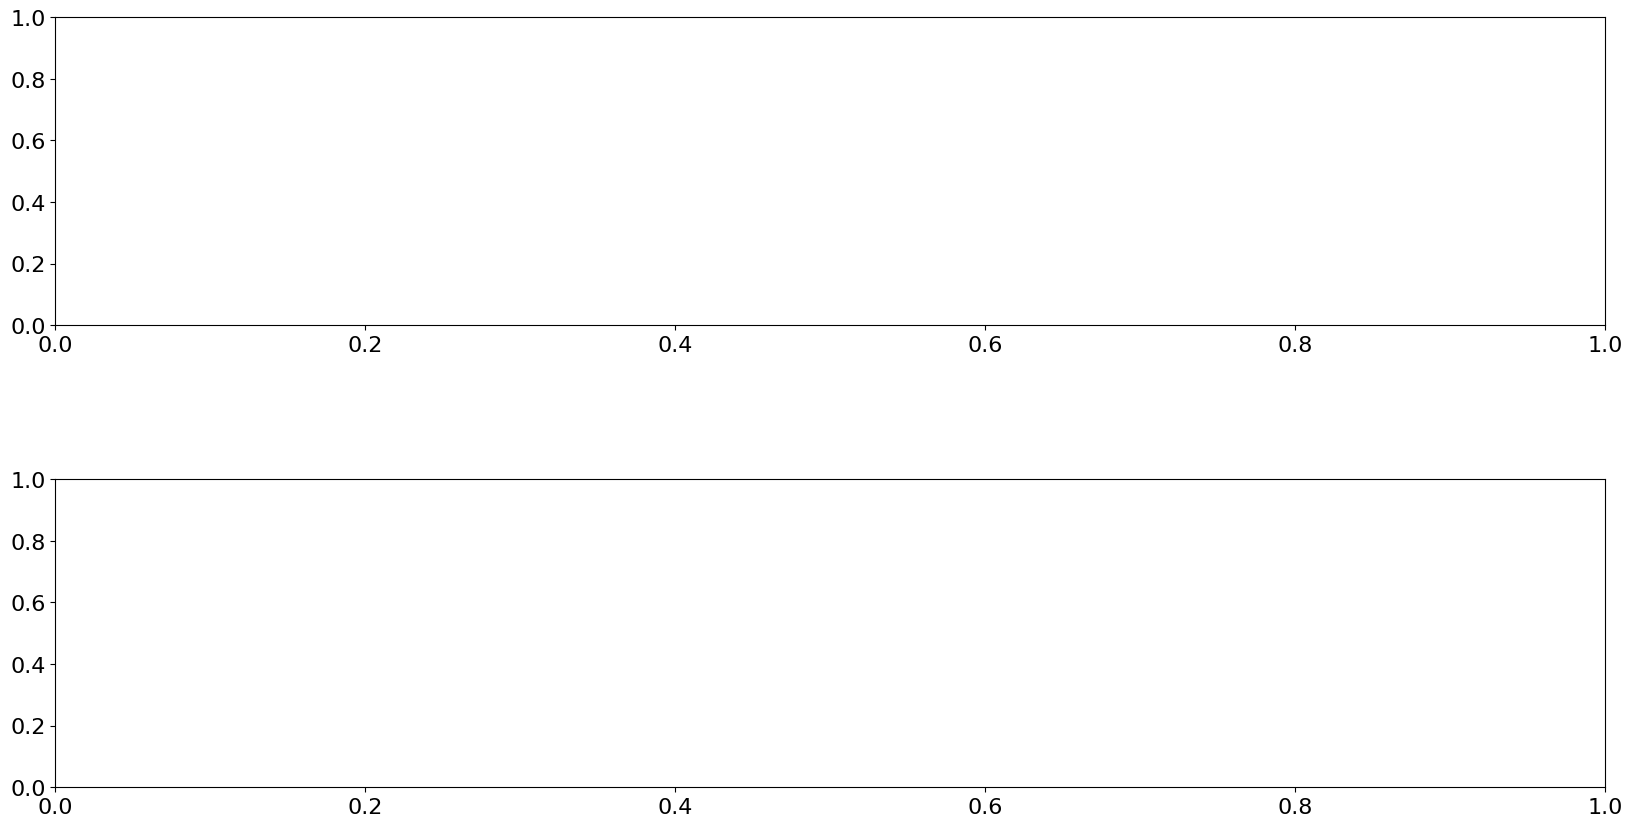

In [31]:
fuel_statistics = backtest_smac(fuel_futures_data, fuel_futures, short_lb, long_lb)

In [ ]:
fuel_statistics

,CL,NG,BZ,RB,HO,STATISTICS
0,-0.419700,-0.399900,-0.413100,-0.319600,-0.411700,min
1,0.430300,0.274200,0.347800,0.308400,0.321800,max
2,0.001896,0.002827,0.002037,0.000000,0.004955,median
3,0.004572,0.000405,0.001737,-0.002316,0.002145,mean
4,0.098390,0.098780,0.095490,0.097170,0.096760,std
5,-0.080130,-0.193200,-0.153400,-0.070410,-0.124600,skew
6,1.170000,0.103600,0.444700,-0.592800,0.549200,ann_mean
7,1.574000,1.580000,1.528000,1.555000,1.548000,ann_std
8,0.743500,0.065560,0.291100,-0.381300,0.354700,sharpe
9,1.144000,0.101200,0.441600,-0.614600,0.569700,sortino


#### 3.2 SMAC on Equity Results

2023-06-23 01:05:56 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:05:56 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:05:56 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:05:56 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:05:56 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
-1.6352213004722755
-1.660656496405356
-0.94511656275504
0.0027414991455234627
4.046685018306029


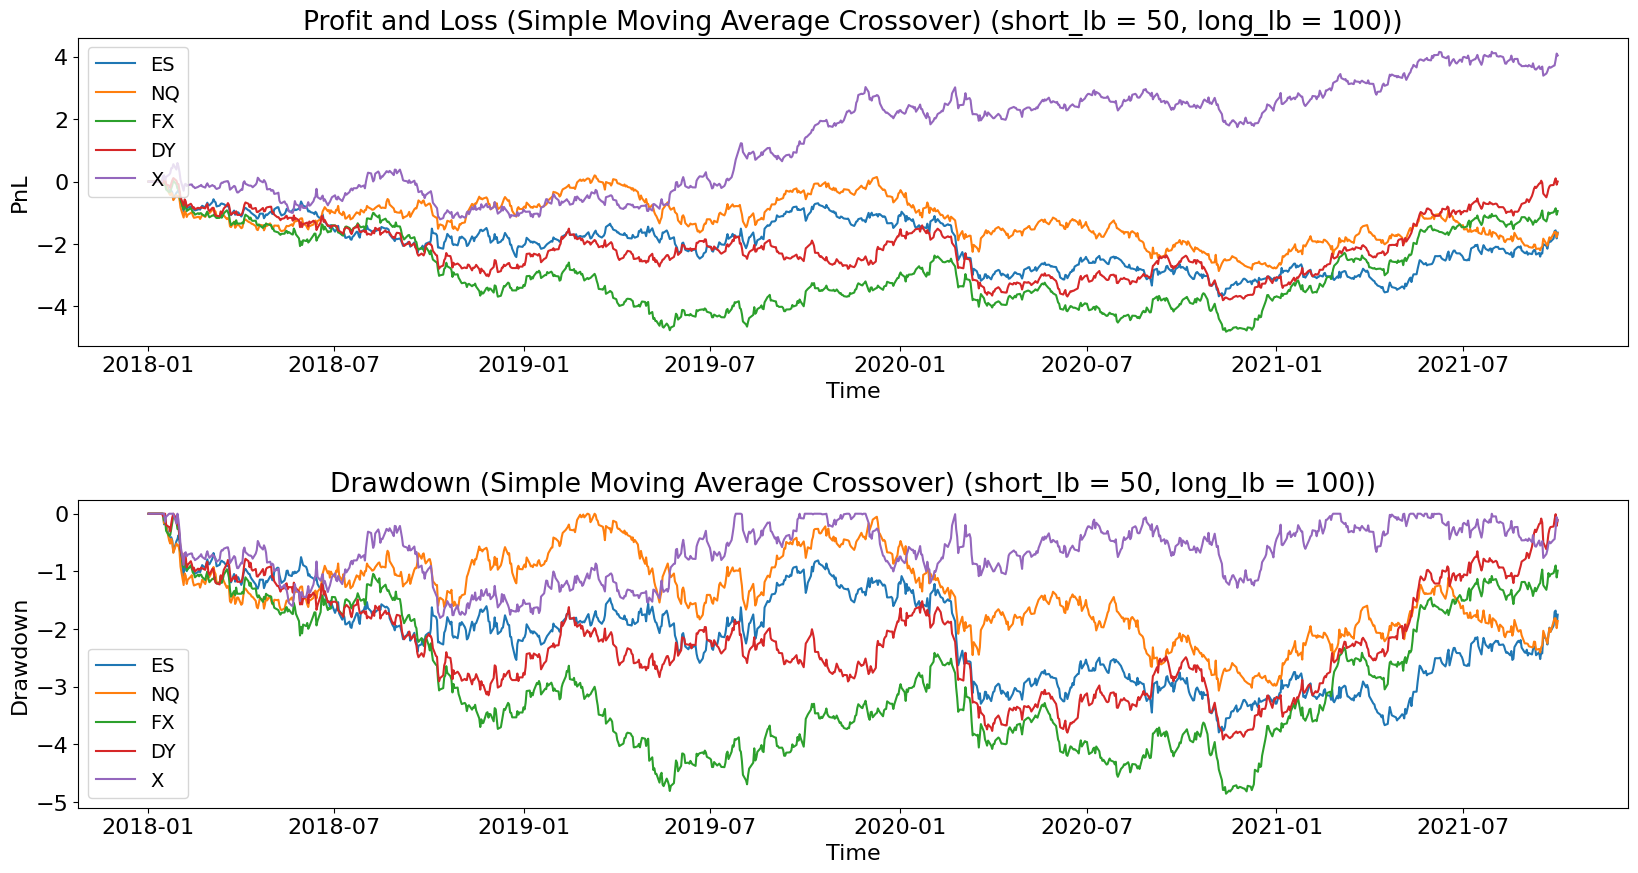

In [ ]:
equity_statistics = backtest_smac(equity_futures_data, equity_futures, short_lb, long_lb)

In [ ]:
equity_statistics

,ES,NQ,FX,DY,X,STATISTICS
0,-0.385300,-0.360900,-0.383000,-0.343900,-0.346700,min
1,0.371300,0.337800,0.369800,0.358900,0.313200,max
2,-0.000791,-0.000934,0.000000,0.002499,0.005183,median
3,-0.001670,-0.001696,-0.000965,0.000003,0.004133,mean
4,0.097430,0.097420,0.097340,0.095620,0.096040,std
5,0.013900,-0.009046,-0.084670,-0.274300,-0.202800,skew
6,-0.427600,-0.434200,-0.247100,0.000717,1.058000,ann_mean
7,1.559000,1.559000,1.557000,1.530000,1.537000,ann_std
8,-0.274300,-0.278600,-0.158700,0.000469,0.688600,sharpe
9,-0.426500,-0.440800,-0.242400,0.000679,1.053000,sortino


### 4. EWMAC Trading Strategy

In [ ]:
def forecast_ewmac(price: pd.Series, short_lb: int, long_lb: int):
    """_summary_

    Args:
        price (pd.Series): _description_
        short_lb (int): _description_
        long_lb (int): _description_

    Returns:
        _type_: _description_
    """

    fast_ewma = price.ewm(span=short_lb).mean()
    slow_ewma = price.ewm(span=long_lb).mean()
    raw_ewmac = fast_ewma - slow_ewma
    forecast = raw_ewmac.where(raw_ewmac > 0, 1.0)
    forecast = forecast.where(raw_ewmac < 0, -1.0)
    return forecast

In [ ]:
def backtest_ewmac(source_dataframe: pd.DataFrame, futures_symbols: list, short_lb: int, long_lb: int):
    """Perform backtest of EWMAC trading strategy on the futures_symbols present in source_dataframe.

    Args:
        source_dataframe (pd.DataFrame): _description_
        futures_symbols (list): _description_
        short_lb (int): _description_
        long_lb (int): _description_

    Returns:
        _type_: _description_
    """

    # Set up a dataframe that will record the backtesting statistics for the backtest of each futures symbol
    account_statistics = pd.DataFrame(columns=futures_symbols)

    # Set up plotting for equity curves and drawdown
    fig, axs = plt.subplots(2, 1, figsize=(20,10))
    fig.subplots_adjust(hspace=0.5)

    # Convert source_dataframe into csv files
    convert_parquet_to_csv(source_dataframe, CSV_PATH, futures_symbols)

    # Convert csv files into pysystemtrade's Data object
    instrument_data = csvFuturesSimData(csv_data_paths=dict(csvFuturesAdjustedPricesData="data.firstrate_futures"))

    for i, column in enumerate(futures_symbols):
        
        # Get raw hourly prices
        price = instrument_data.daily_prices(column)

        # Get smac forecasts on price movement
        ewmac_forecast = forecast_ewmac(price, short_lb, long_lb)
        ewmac_forecast.columns = ['forecast']

        # Run backtest
        account = pandl_for_instrument_forecast(forecast=ewmac_forecast, price=price)

        # Plot equity curve and drawdown curve
        plot_pnl_and_drawdown_curves(account, column, f'{EWMAC_TITLE}) (short_lb = {short_lb}, long_lb = {long_lb})', axs)

        account_statistics['STATISTICS'] = pd.Series(list(dict(account.percent.stats()[0]).keys()))

        account_statistics[futures_symbols[i]] = pd.Series(
            [float(x) for x in list(dict(account.percent.stats()[0]).values())])

        print(account.curve().iloc[-1])

    return account_statistics

#### 4.1 EWMAC on Fuel Results

2023-06-23 01:05:57 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:05:57 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:05:57 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:05:57 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:05:57 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
0.23789880834367605
-2.3481651297510777
-0.48614134158404193
-1.786977081830047
0.29829521004104553


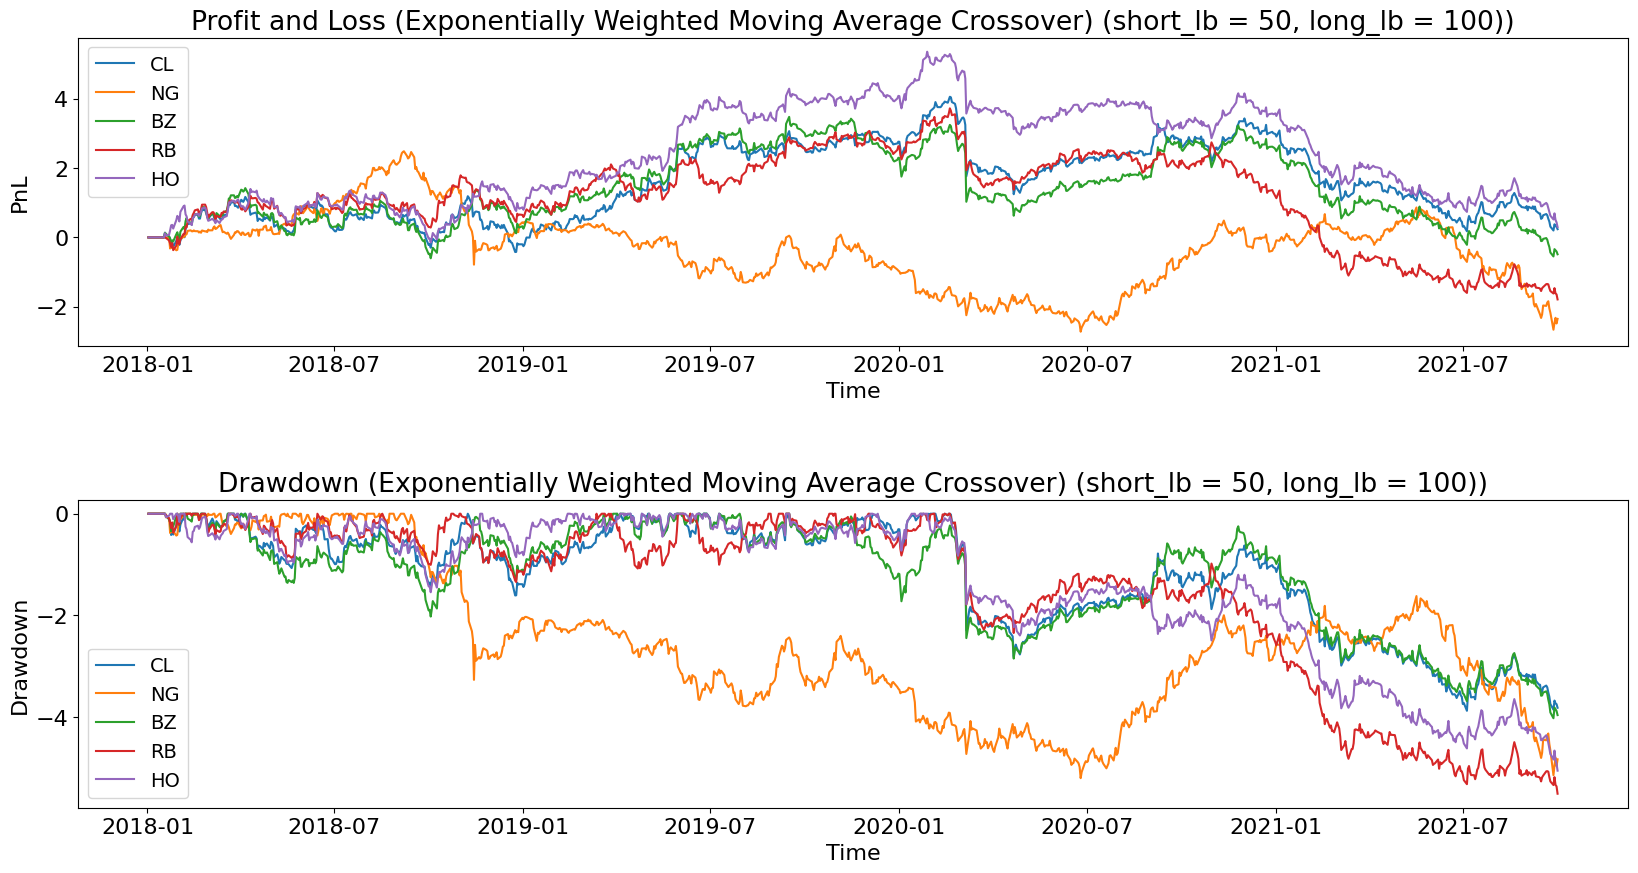

In [ ]:
ewmac_fuel_statistics = backtest_ewmac(fuel_futures_data, fuel_futures, short_lb, long_lb)

In [ ]:
ewmac_fuel_statistics

,CL,NG,BZ,RB,HO,STATISTICS
0,-1.482000,-0.790000,-1.394000,-0.934800,-1.010000,min
1,0.546800,0.687600,0.549400,0.422100,0.465800,max
2,0.000000,0.000000,-0.001268,-0.000899,-0.000534,median
3,0.000243,-0.002399,-0.000497,-0.001825,0.000305,mean
4,0.113100,0.110200,0.112500,0.107200,0.108300,std
5,-2.056000,-0.266100,-1.571000,-0.507700,-0.488100,skew
6,0.062210,-0.614000,-0.127100,-0.467300,0.078000,ann_mean
7,1.809000,1.763000,1.799000,1.716000,1.732000,ann_std
8,0.034380,-0.348200,-0.070640,-0.272400,0.045030,sharpe
9,0.042760,-0.489300,-0.092860,-0.392900,0.066860,sortino


#### 4.1 EWMAC on Equity Results

2023-06-23 01:05:58 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:05:58 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:05:58 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:05:58 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 01:05:58 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
0.11275534606346288
-1.4531201681141475
2.970521494035593
1.6478649879655416
-1.9698512275387436


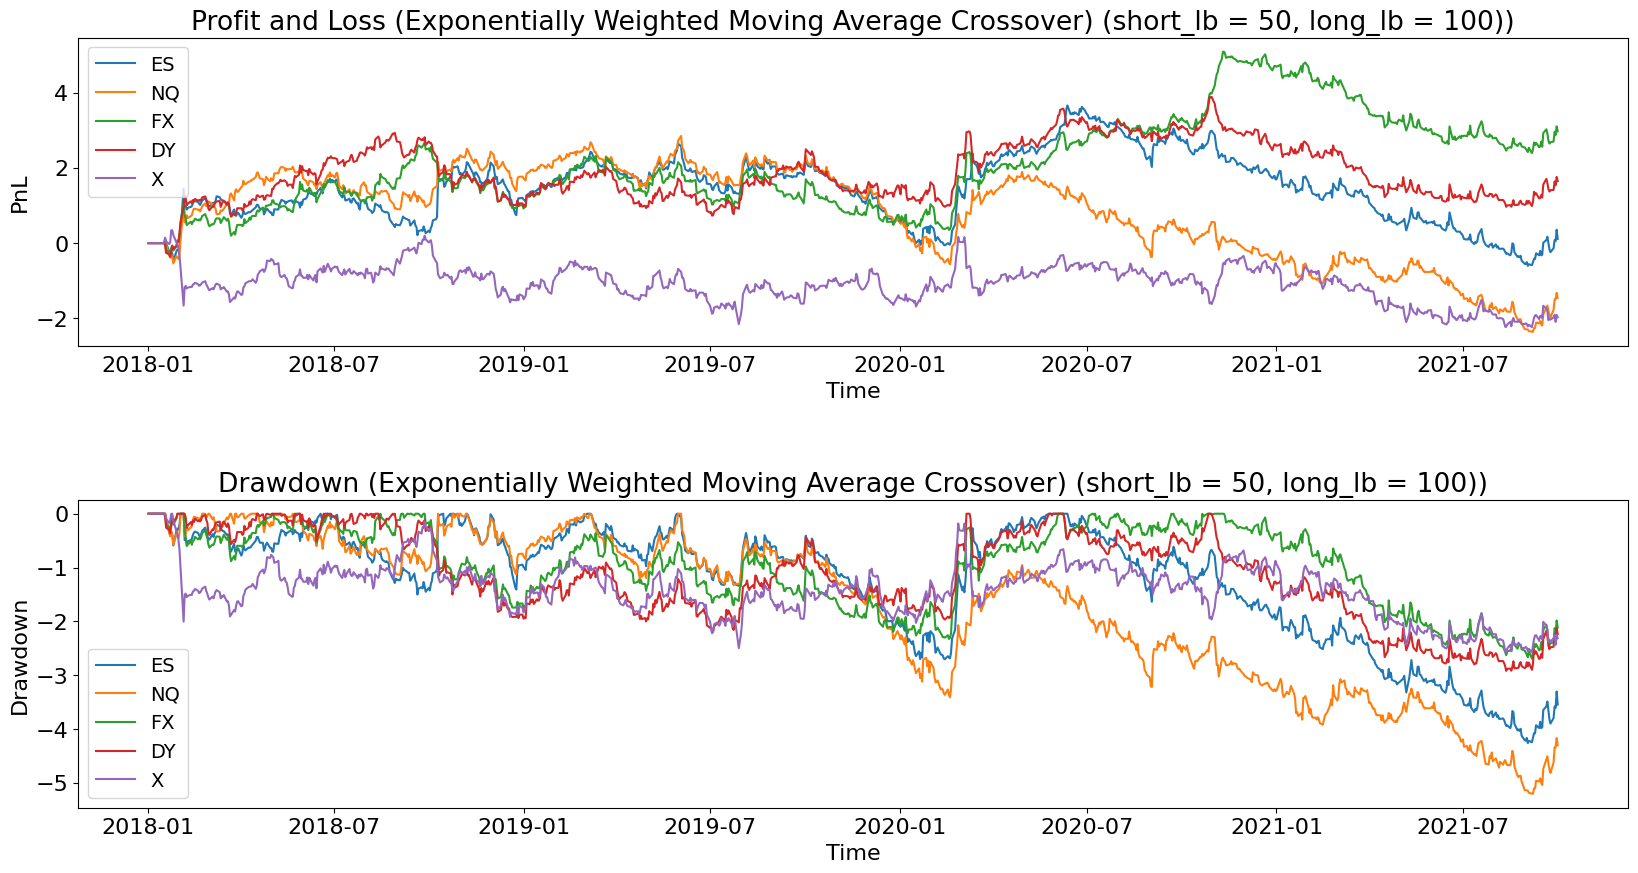

In [ ]:
ewmac_equity_statistics = backtest_ewmac(equity_futures_data, equity_futures, short_lb, long_lb)

In [ ]:
ewmac_equity_statistics

,ES,NQ,FX,DY,X,STATISTICS
0,-0.492000,-0.419100,-0.347800,-0.362300,-0.998500,min
1,1.142000,0.879400,0.542200,0.431700,0.496300,max
2,-0.006425,-0.008874,0.000000,0.000000,0.000000,median
3,0.000115,-0.001484,0.003034,0.001683,-0.002012,mean
4,0.115200,0.110500,0.107300,0.105300,0.109800,std
5,2.050000,1.194000,0.538100,0.315700,-0.673600,skew
6,0.029480,-0.380000,0.776800,0.430900,-0.515100,ann_mean
7,1.844000,1.769000,1.717000,1.685000,1.757000,ann_std
8,0.015990,-0.214900,0.452500,0.255700,-0.293100,sharpe
9,0.030310,-0.399200,0.766600,0.419900,-0.401600,sortino
